In [ ]:
# ===== conda env: (rapid-23.12) =====
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # MUST be first!


import grapheno
import cudf
import pandas as pd
import glob
import subprocess
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist


print(f"cuDF version: {cudf.__version__}")

grapheno.generate_dummy_data(n_samples = 5000000,
                             n_features = 20,
                             centers = 30,
                             cluster_std=4.0)

# Clean all cache files
print("Cleaning up ALL cache files...")
subprocess.run(['rm', '-f', '*.parquet'], shell=True, check=False)
subprocess.run(['rm', '-f', 'chunk_*.csv'], shell=True, check=False)

print("\nLoading full dataset...")
full_data = pd.read_csv('dummy_data.csv')
print(f"Total samples: {len(full_data)}")

# Process in chunks
feature_cols = [f'feature{i+1}' for i in range(20)]
chunk_size = 10000  # Small chunks to fit in GPU memory
n_neighbors = 30   # Reduced to save memory
# ==================================================
# STEP 1: Cluster each chunk with grapheno
# ==================================================
print("\n" + "="*60)
print("STEP 1: Clustering each chunk with grapheno")
print("="*60)

chunk_results = []  # Store (chunk_data, cluster_centroids)
all_centroids = []  # All centroids from all chunks
centroid_metadata = []  # Track which chunk and cluster each centroid came from

total_chunks = (len(full_data) + chunk_size - 1) // chunk_size

for i in range(0, len(full_data), chunk_size):
    chunk_num = i // chunk_size + 1
    print(f"\nChunk {chunk_num}/{total_chunks}")
    
    # Extract chunk
    chunk = full_data.iloc[i:i+chunk_size].copy()
    chunk_file = f'chunk_{chunk_num}.csv'
    chunk.to_csv(chunk_file, index=False)
    
    try:
        # Cluster this chunk
        df_chunk = grapheno.cluster(chunk_file, 
                                     feature_cols,
                                     n_neighbors=n_neighbors,
                                     distributed_knn=False,
                                     distributed_graphs=False, 
                                     min_size=5)
        
        df_chunk_pd = df_chunk.to_pandas() if isinstance(df_chunk, cudf.DataFrame) else df_chunk
        
        # Compute centroids for this chunk
        chunk_centroids = {}
        for cluster_id in df_chunk_pd['cluster'].unique():
            if cluster_id >= 0:  # Ignore noise
                cluster_points = df_chunk_pd[df_chunk_pd['cluster'] == cluster_id][feature_cols]
                centroid = cluster_points.mean().values
                chunk_centroids[cluster_id] = centroid
                
                # Store centroid with metadata
                all_centroids.append(centroid)
                centroid_metadata.append({
                    'chunk_num': chunk_num,
                    'original_cluster': cluster_id,
                    'start_idx': i,
                    'end_idx': min(i + chunk_size, len(full_data))
                })
        
        chunk_results.append({
            'chunk_num': chunk_num,
            'data': df_chunk_pd,
            'centroids': chunk_centroids,
            'start_idx': i,
            'end_idx': min(i + chunk_size, len(full_data))
        })
        
        print(f"✅ Found {len(chunk_centroids)} clusters")
        
    except Exception as e:
        print(f"❌ Failed: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        # Cleanup
        try:
            os.remove(chunk_file)
            for cache in glob.glob('*.parquet'):
                os.remove(cache)
        except:
            pass

# ==================================================
# STEP 2: Merge similar clusters across chunks
# ==================================================
print("\n" + "="*60)
print("STEP 2: Merging similar clusters")
print("="*60)

all_centroids = np.array(all_centroids)
print(f"Total centroids from all chunks: {len(all_centroids)}")

# Use hierarchical clustering to group similar centroids
# Distance threshold determines how similar centroids must be to merge
distance_threshold = 2.0  # Adjust based on your data scale

hierarchical = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=distance_threshold,
    linkage='average',
    metric='euclidean'
)

merged_cluster_labels = hierarchical.fit_predict(all_centroids)
n_merged_clusters = len(np.unique(merged_cluster_labels))

print(f"Merged into {n_merged_clusters} global clusters")

# Create mapping: (chunk_num, original_cluster) -> merged_cluster
cluster_mapping = {}
for i, meta in enumerate(centroid_metadata):
    key = (meta['chunk_num'], meta['original_cluster'])
    cluster_mapping[key] = merged_cluster_labels[i]

# ==================================================
# STEP 3: Apply merged cluster labels to all data
# ==================================================
print("\n" + "="*60)
print("STEP 3: Applying merged cluster labels")
print("="*60)

final_clusters = np.zeros(len(full_data), dtype=int)

for chunk_info in chunk_results:
    chunk_num = chunk_info['chunk_num']
    chunk_data = chunk_info['data']
    start_idx = chunk_info['start_idx']
    end_idx = chunk_info['end_idx']
    
    # Map each point's original cluster to merged cluster
    for idx, row in chunk_data.iterrows():
        original_cluster = row['cluster']
        if original_cluster >= 0:
            key = (chunk_num, original_cluster)
            merged_cluster = cluster_mapping.get(key, -1)
            final_clusters[start_idx + idx] = merged_cluster
        else:
            final_clusters[start_idx + idx] = -1  # Noise

# Create final dataframe
final_df = full_data.copy()
final_df['cluster'] = final_clusters

print(f"\n✅ Complete!")
print(f"Total samples: {len(final_df)}")
print(f"Original clusters (before merge): {len(all_centroids)}")
print(f"Final clusters (after merge): {n_merged_clusters}")
print(f"\nCluster distribution:")
print(final_df['cluster'].value_counts().sort_index().head(10))

# Save results
final_df.to_csv('clustered_results.csv', index=False)
print(f"\nSaved to clustered_results.csv")

# Convert to cuDF
df = cudf.from_pandas(final_df)
df.head()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
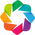

/opt/miniforge3/envs/rapids-23.12/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [14:44:43.573697] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


:Layout
   .Scatter.I  :Scatter   [TSNE1]   (TSNE2,label)
   .Scatter.II :Scatter   [TSNE1]   (TSNE2,cluster)

In [2]:
import cuml
import holoviews as hv
hv.extension('bokeh')

X = df[[i for i in df.columns if 'feature' in i]].sample(50000)

tsne = cuml.TSNE(random_state=42, n_neighbors=300)
tsne_coords = tsne.fit_transform(X).to_pandas().rename(columns={0:'TSNE1',1:'TSNE2'})
tsne_coords['label'] = df['label'][X.index].to_numpy()
tsne_coords['cluster'] = df['cluster'][X.index].to_numpy()
sample = tsne_coords.sample(5000)

plots = [hv.Scatter(sample,
                    'TSNE1',
                   ['TSNE2',i]).opts(cmap='glasbey',
                                          color=hv.dim(i),
                                          padding=0.05,
                                          height=500,
                                          title=i,
                                          width=500,
                                          xaxis=None,
                                          yaxis=None)

    for i in ['label','cluster']]

hv.Layout(plots)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
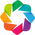

:Layout
   .Scatter.I  :Scatter   [UMAP1]   (UMAP2,label)
   .Scatter.II :Scatter   [UMAP1]   (UMAP2,cluster)

In [3]:
import cuml
import holoviews as hv
hv.extension('bokeh')

# Using UMAP
X = df[[i for i in df.columns if 'feature' in i]].sample(50000)

umap = cuml.UMAP(random_state=42, n_neighbors=20)
umap_coords = umap.fit_transform(X).to_pandas().rename(columns={0:'UMAP1',1:'UMAP2'})
umap_coords['label'] = df['label'][X.index].to_numpy()
umap_coords['cluster'] = df['cluster'][X.index].to_numpy()
sample = umap_coords.sample(5000)

plots = [hv.Scatter(sample,
                    'UMAP1',
                   ['UMAP2',i]).opts(cmap='glasbey',
                                          color=hv.dim(i),
                                          padding=0.05,
                                          height=500,
                                          title=i,
                                          width=500,
                                          xaxis=None,
                                          yaxis=None)

    for i in ['label','cluster']]

hv.Layout(plots)